In [1]:
import numpy as np
import matplotlib.pyplot as plt
import imageio

def read_raw_file(file_path, width, height, depth, dtype=np.uint8):
    # Read a raw file and reshape it into a 3D volume
    with open(file_path, 'rb') as file:
        raw_data = file.read()
    volume = np.frombuffer(raw_data, dtype=dtype)
    volume = volume.reshape((depth, height, width))
    return volume

def read_tif_file(file_path):
    # Read a .tif file as a 3D volume
    volume = imageio.volread(file_path)
    return volume

# If your data type is ".raw", use read_raw_file to load the data
# width = 630
# height = 410
# depth = 510
# dtype = np.uint16
# file_path = 'images/60Wet.tif'
# volume = read_raw_file(file_path, width, height, depth, dtype=dtype)

# If your data type is ".tif", use read_tif_file to load the data
file_path = '/rds/general/user/sye/home/Unsupervised/images/Shanlin/mix_fw50_filtered.tif'
volume = read_tif_file(file_path)
print(volume.shape)


(500, 500, 500)


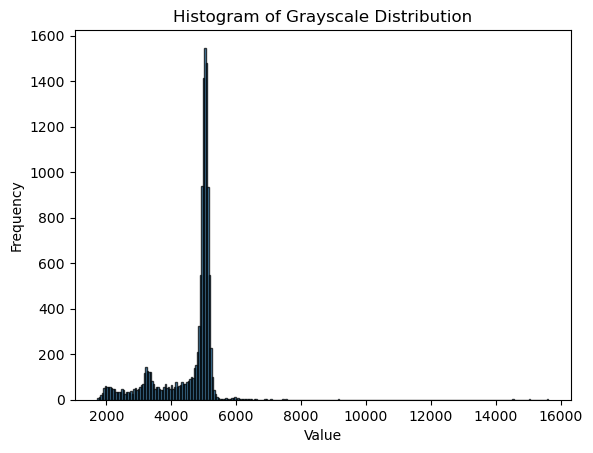

In [2]:
# Observe the grayscale distribution of the image
sample = volume.flatten()  # Flatten the 3D volume into a 1D array
# Randomly sample 0.01% of the data for visualization
sample_size = int(0.0001 * sample.size)
random_indices = np.random.choice(sample.size, sample_size, replace=False)
sample_subset_after = sample[random_indices]
# Plot a histogram with 300 bins
n, bins, patches = plt.hist(sample_subset_after, bins=300, alpha=0.75, edgecolor='black')
# Add a title and labels
plt.title('Histogram of Grayscale Distribution')
plt.xlabel('Value')
plt.ylabel('Frequency')
# Display the plot
plt.show()

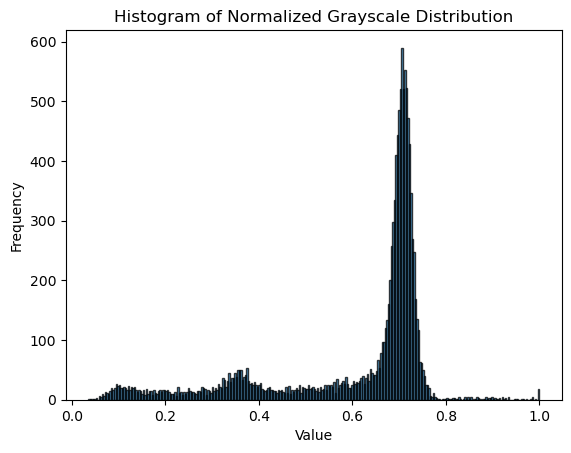

In [3]:
# Normalize the image data to the range 0-1
volume_copy = volume.copy()
# Clip values outside the range [1500, 6500]
volume_copy[volume_copy > 6500] = 6500
volume_copy[volume_copy < 1500] = 1500
# Calculate the minimum and maximum values for normalization
min_val = np.min(volume_copy)
max_val = np.max(volume_copy)
# Normalize the data to the range [0, 1]
normalized_volume = (volume_copy - min_val) / (max_val - min_val)
# Flatten the normalized volume for sampling
sample = normalized_volume.flatten()
# Randomly sample 0.01% of the data for visualization
sample_size = int(0.0001 * sample.size)
random_indices = np.random.choice(sample.size, sample_size, replace=False)
sample_subset_after = sample[random_indices]
# Plot a histogram with 300 bins
n, bins, patches = plt.hist(sample_subset_after, bins=300, alpha=0.75, edgecolor='black')
# Add title and labels
plt.title('Histogram of Normalized Grayscale Distribution')
plt.xlabel('Value')
plt.ylabel('Frequency')
# Display the plot
plt.show()

In [4]:
import numpy as np
from numba import jit, prange, get_num_threads, config, njit
from math import exp, ceil
import time

# Set the number of threads for parallel computing. Choose an appropriate number based on your device.
# More threads can lead to faster execution.
from numba import set_num_threads
set_num_threads(8)

# Compute the density of each voxel
@jit(nopython=True, parallel=True, fastmath=True)
def compute_densities_3d(densities, kernel_size):
    inv_kernel_size_sqr = -0.5 / (kernel_size * kernel_size)
    kernel_width = int(ceil(1 * kernel_size))
    for d in prange(depth):
        d_min = max(d - 1, 0)
        d_max = min(d + 1, depth)
        for r in range(height):
            r_min = max(r - kernel_width, 0)
            r_max = min(r + kernel_width, height)
            for c in range(width):
                c_min = max(c - kernel_width, 0)
                c_max = min(c + kernel_width, width)
                for d_ in range(d_min, d_max):
                    for r_ in range(r_min, r_max):
                        for c_ in range(c_min, c_max):
                            dist = 0.0
                            t = image[d, r, c] - image[d_, r_, c_]
                            dist += t * t
                            t = d - d_
                            dist += t * t
                            t = r - r_
                            dist += t * t
                            t = c - c_
                            dist += t * t
                            densities[d, r, c] += np.exp(dist * inv_kernel_size_sqr)

    return densities

# Find the supervoxel center for each voxel
@jit(nopython=True, parallel=True, fastmath=True)
def find_nearest_node(kernel_size, densities, parent):
    kernel_width = int(ceil(1 * kernel_size))
    for d in prange(depth):
        d_min = max(d - kernel_width, 0)
        d_max = min(d + kernel_width + 1, depth)
        for r in range(height):
            r_min = max(r - kernel_width, 0)
            r_max = min(r + kernel_width + 1, height)
            for c in range(width):
                current_density = densities[d, r, c]
                closest = np.inf
                c_min = max(c - kernel_width, 0)
                c_max = min(c + kernel_width + 1, width)
                for d_ in range(d_min, d_max):
                    for r_ in range(r_min, r_max):
                        for c_ in range(c_min, c_max):
                            if densities[d_, r_, c_] > current_density:
                                parent[d, r, c] = d_ * height * width + r_ * width + c_
                                current_density = densities[d_, r_, c_]

    return parent

# Hyperparameter selection
image0 = normalized_volume
depth, height, width = image0.shape
ratio = 10
image = np.ascontiguousarray(image0 * ratio)
kernel_size = 1
# kernel_size is an important hyperparameter:
# kernel_size = 1 is suitable for high-quality images and can capture fine pores.
# kernel_size = 3 is suitable for low-quality images, as it can reduce noise and reconstruct artifacts.

start_time = time.time()

# Compute densities
densities0 = np.zeros((depth, height, width))
densities = compute_densities_3d(densities0, kernel_size)
print("1.Density estimation completed")

# Form superpixels
parent = np.arange(depth * height * width, dtype=np.int32).reshape(depth, height, width)
parent = find_nearest_node(kernel_size, densities, parent)
parent_flat = parent.ravel()
old = np.zeros_like(parent_flat)
while (old != parent_flat).any():
    old = parent_flat
    parent_flat = parent_flat[parent_flat]
print("2.Superpixels formed")

# Replace values with grayscale values
@njit
def replace_values(x, y):
    return x[y]
image0_mark = image0.ravel()
result = replace_values(image0_mark, parent_flat)
result = result.reshape(depth, height, width)
print("3.Replacement completed")

end_time = time.time()
elapsed_time = end_time - start_time
print('Elapsed time (s):', elapsed_time)

1.Density estimation completed
2.Superpixels formed
3.Replacement completed
Elapsed time (s): 7.5339133739471436


Number of superpixel segments: 8448
(500, 500)


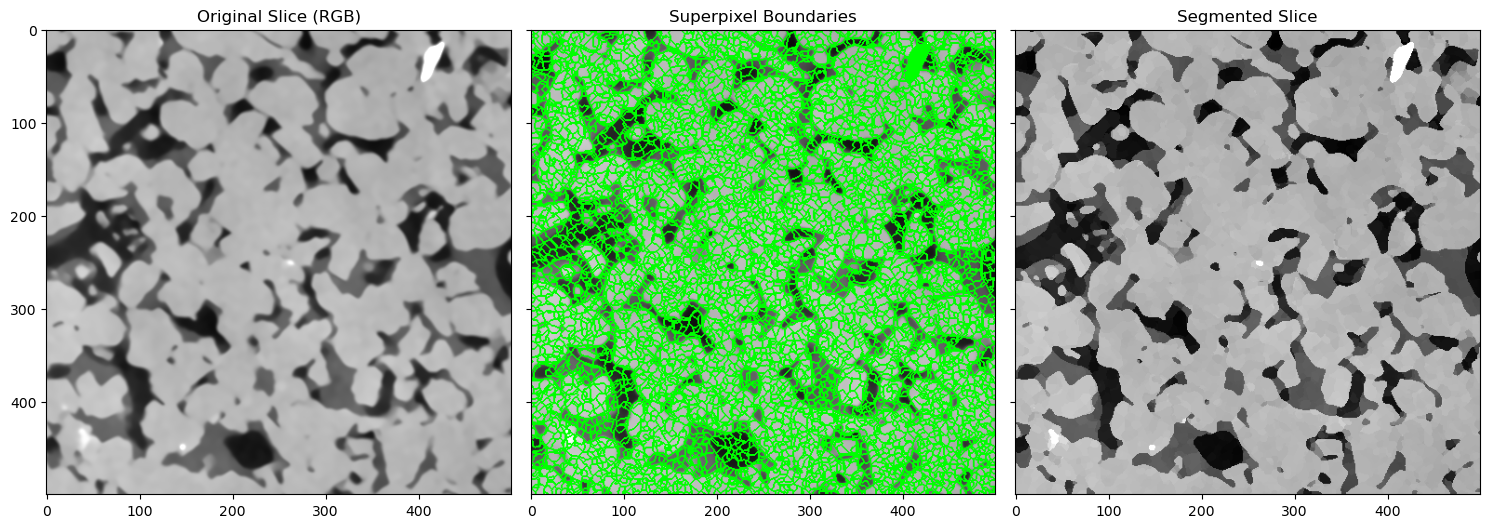

In [5]:
from skimage import segmentation
# Select a slice for visualization
slice_index = 100
slice_result = result[slice_index, :, :]  # Extract the segmented slice
slice0_ = image0[slice_index, :, :]  # Extract the original grayscale slice
# Create an RGB representation of the original slice
slice_rgb = np.stack([slice0_] * 3, axis=-1)
# Brighten the image for better visualization
scale_factor = 1  # Adjust this factor to control brightness
slice_rgb = np.clip(slice_rgb * scale_factor, 0, 1)
# Extract superpixel labels from the parent array
q_labels_ = parent_flat.reshape(depth, height, width)[slice_index, :, :]
print(f'Number of superpixel segments: {len(np.unique(q_labels_))}')
print(slice0_.shape)
# Visualize the original slice, superpixels with boundaries, and segmented result
fig, ax = plt.subplots(1, 3, figsize=(15, 15), sharex=True, sharey=True)
# Mark superpixel boundaries on the RGB slice
q_label_img = segmentation.mark_boundaries(slice_rgb, q_labels_, (0, 1, 0))  # Boundaries in green
# Display the images
ax[0].imshow(slice_rgb)
ax[0].set_title("Original Slice (RGB)")
ax[1].imshow(q_label_img)
ax[1].set_title("Superpixel Boundaries")
ax[2].imshow(slice_result, cmap='gray')
ax[2].set_title("Segmented Slice")
plt.tight_layout()
plt.show()

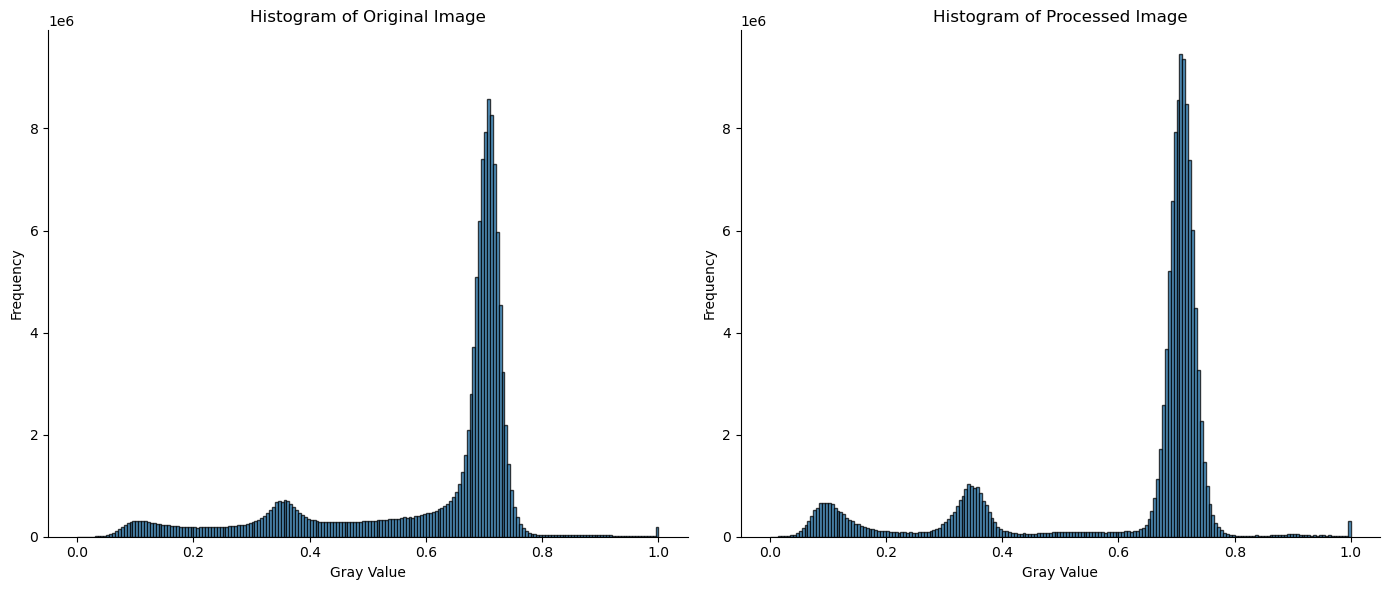

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Flatten the processed and original 3D images
sample1 = result[:, :, :].flatten()  # Processed image
sample_size = int(1 * sample1.size)  # Use the full sample size for this visualization
random_indices = np.random.choice(sample1.size, sample_size, replace=False)  # Random sampling indices
sample_subset_after1 = sample1[random_indices]  # Subsample the processed image

sample2 = image0[:, :, :].flatten()  # Original image
sample_subset_after2 = sample2[random_indices]  # Subsample the original image

# Create a figure with two subplots for side-by-side comparison
fig, ax = plt.subplots(1, 2, figsize=(14, 6), sharex=True, sharey=True)

# Plot histograms for the original and processed images
n, bins, patches = ax[0].hist(sample_subset_after2, bins=200, alpha=0.75, edgecolor='black')  # Original
n, bins, patches = ax[1].hist(sample_subset_after1, bins=200, alpha=0.75, edgecolor='black')  # Processed

# Add titles, labels, and formatting
ax[0].set_title('Histogram of Original Image')
ax[1].set_title('Histogram of Processed Image')
ax[0].set_xlabel('Gray Value')
ax[0].set_ylabel('Frequency')
ax[1].set_xlabel('Gray Value')
ax[1].set_ylabel('Frequency')

# Remove the top and right spines for cleaner appearance
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)

# Ensure both subplots show the same y-axis tick marks
ax[1].tick_params(axis='y', labelleft=True)

# Display the plot
plt.tight_layout()
plt.show()

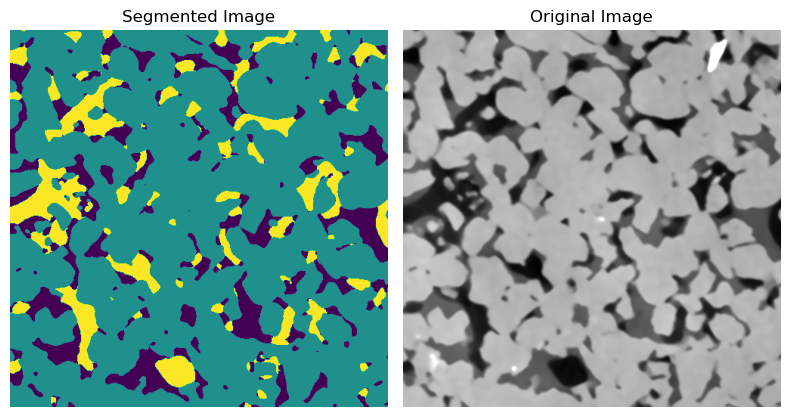

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import tifffile

# Segment the result into different phases based on grayscale thresholds
mask_oil = (result <= 0.22)  # Oil phase
mask_water = (result > 0.22) & (result <= 0.5)  # Water phase
mask_rock = (result > 0.5)  # Rock phase

# Convert segmented regions into labeled integers
new_center = np.zeros_like(result, dtype=np.uint8)
new_center[mask_oil] = 2  # Label oil phase as 2
new_center[mask_water] = 0  # Label water phase as 0
new_center[mask_rock] = 1  # Label rock phase as 1

# Visualize the segmentation results
fig, axes = plt.subplots(1, 2, figsize=(8, 6))
index = 100  # Slice index for visualization

# Display the segmented slice
axes[0].imshow(new_center[index, :, :], cmap='viridis')  # Use a colormap for better visibility
axes[0].set_title('Segmented Image')
axes[0].axis('off')

# Display the original slice for comparison
axes[1].imshow(image0[index, :, :], cmap='gray')
axes[1].set_title('Original Image')
axes[1].axis('off')

plt.tight_layout()
plt.show()

# Save the segmented result to a file
# Uncomment the following line to save the data
# new_center.astype(np.uint8).tofile("mix_fw50_segmented.raw")

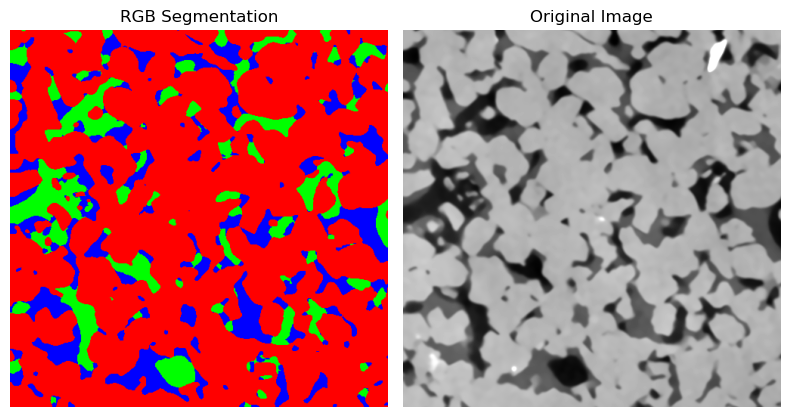

In [9]:
# Create RGB visualization
index = 100  # Choose slice index
seg_rgb = new_center[index, :, :]
img_rgb = np.zeros((seg_rgb.shape[0], seg_rgb.shape[1], 3), dtype=np.uint8)
img_rgb[seg_rgb == 0] = [0, 0, 255]  # Blue for water
img_rgb[seg_rgb == 1] = [255, 0, 0]  # Red for rock
img_rgb[seg_rgb == 2] = [0, 255, 0]  # Green for oil

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(8, 6))
axes[0].imshow(img_rgb)
axes[0].set_title('RGB Segmentation')
axes[0].axis('off')

# Display original image
axes[1].imshow(image0[index, :, :], cmap='gray')
axes[1].set_title('Original Image')
axes[1].axis('off')

plt.tight_layout()
plt.show()